In [15]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline
import statsmodels.api as sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# United States

## Data Manipulation

In [188]:
#import us dataset
super_data = pd.read_csv("../data/covid_large.csv")

#display dataset
super_data.head()

,State,countyFIPS,County Name,Date,Num of Cases,Num of Deaths,population
0,AL,0,statewide unallocated,2020-01-22,0,0,0
1,AL,0,statewide unallocated,2020-01-23,0,0,0
2,AL,0,statewide unallocated,2020-01-24,0,0,0
3,AL,0,statewide unallocated,2020-01-25,0,0,0
4,AL,0,statewide unallocated,2020-01-26,0,0,0


In [189]:
#take difference of cases and deaths to obtain new cases and deaths
super_data['Num of Cases Per Day'] = super_data['Num of Cases'].diff()
super_data['Num of Deaths Per Day'] = super_data['Num of Deaths'].diff()

#remove unessesary rows from dataset
super_data= super_data[super_data['Date'] != '2020-01-22']

#group us dataset by date
super_data = super_data.groupby("Date").sum().reset_index()

#convert time from object to datetime
super_data['Date'] = super_data.Date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))

#drop unnessesary columns
super_data = super_data.drop(['countyFIPS','Num of Cases','Num of Deaths'],axis=1)

#display dataset
super_data.head()

,Date,population,Num of Cases Per Day,Num of Deaths Per Day
0,2020-01-23,328239523,0.0,0.0
1,2020-01-24,328239523,1.0,0.0
2,2020-01-25,328239523,0.0,0.0
3,2020-01-26,328239523,3.0,0.0
4,2020-01-27,328239523,1.0,0.0


In [190]:
#obtain the date of the first case
first_case_index = super_data['Num of Cases Per Day'].ne(0).idxmax() 

#obtain the date of the first death
first_death_index= super_data['Num of Deaths Per Day'].ne(0).idxmax() 

#list to hold the cases since day 1
numOfCasesSinceDay1=[]

#list to hold the deaths since day 1
numOfDeathsSinceDay1=[]

#loop to compute the number of cases since day 1
counter=1
for i,index in enumerate(range(len(super_data))):
    if i<=first_case_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1

#loop to compute the number of deaths since day 1
counter=1
for i,index in enumerate(range(len(super_data))):
    if i<=first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1

#insert list into dataset as a column
super_data.insert(2, "numOfCasesSinceDay1", numOfCasesSinceDay1)

#insert list into dataset as a column   
super_data.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)

#print dataset
super_data.head()

,Date,population,numOfDeathsSinceDay1,numOfCasesSinceDay1,Num of Cases Per Day,Num of Deaths Per Day
0,2020-01-23,328239523,0,0,0.0,0.0
1,2020-01-24,328239523,0,0,1.0,0.0
2,2020-01-25,328239523,0,1,0.0,0.0
3,2020-01-26,328239523,0,2,3.0,0.0
4,2020-01-27,328239523,0,3,1.0,0.0


## Regression Models of the Cases

In [216]:
#create second dataframe of just the cases data
df_cases = super_data[['numOfCasesSinceDay1','Num of Cases Per Day']]

#print dataframe
df_cases

,numOfCasesSinceDay1,Num of Cases Per Day
0,0,0.0
1,0,1.0
2,1,0.0
3,2,3.0
4,3,1.0
...,...,...
231,230,35510.0
232,231,46286.0
233,232,39133.0
234,233,34792.0


### Linear Regression Model

In [217]:
#obtain x from the dataset as the number of cases since day 1
X = df_cases.iloc[:,0].values.reshape(-1, 1) 

#obtain y from the dataset as the number of cases per day
y = df_cases.iloc[:,1].values.reshape(-1, 1)

#create linear regression model
lm = LinearRegression()

#fit the linear regression model to the data obtained
lm.fit(X, y)

#use the linear regression model to predict the varialbe x
cases_prediction = lm.predict(X)

In [218]:
#print the data for the linear regression model of the cases
print("Evaluation of the Linear Model:")
print("Mean Absolute Error:", metrics.mean_absolute_error(y,cases_prediction))
print("Mean Squared Error:", metrics.mean_squared_error(y,cases_prediction))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,cases_prediction)))
print("R^2 Score:", r2_score(y,cases_prediction))

Evaluation of the Linear Model:
Mean Absolute Error: 9244.824032000502
Mean Squared Error: 134460697.24341974
Sqrt of Mean Squared Error: 11595.718918782903
R^2 Score: 0.6887368036784534


In [220]:
#create future dates
future_dates = np.array([235,236,237,238,239,240,241])
future_dates = np.arange(235,242).reshape(-1,1)

#use linear model to predict dates
future_cases = lm.predict(future_dates)

#display the predicted cases for the future dates
print("Predicted Cases:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', future_cases[i])

Predicted Cases:
[235] - [57552.24252906]
[236] - [57805.45748478]
[237] - [58058.67244051]
[238] - [58311.88739623]
[239] - [58565.10235196]
[240] - [58818.31730769]
[241] - [59071.53226341]


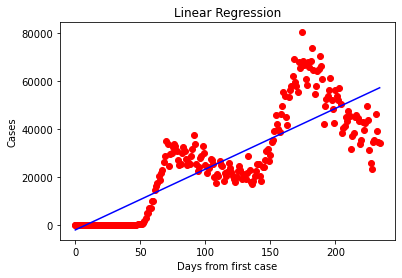

In [221]:
#display the cases with the linear regression on a plot
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lm.predict(X), color='blue')
    plt.title('Linear Regression')
    plt.xlabel('Days from first case')
    plt.ylabel('Cases')
    plt.show()
    return

viz_linear()

### Polynomial Regression Model

In [222]:
#create regression for a polynomial of degree 2
poly = PolynomialFeatures(degree = 2)
poly_features = poly.fit_transform(X)
poly.fit(X,y)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,y)

#create regression for a polynomial of degree 3
poly3 = PolynomialFeatures(degree = 3)
poly_features3 = poly3.fit_transform(X)
poly3.fit(X,y)
poly_regression3 = LinearRegression()
poly_regression3.fit(poly_features3,y)

#create regression for a polynomial of degree 4
poly4 = PolynomialFeatures(degree = 4)
poly_features4 = poly4.fit_transform(X)
poly3.fit(X,y)
poly_regression4 = LinearRegression()
poly_regression4.fit(poly_features4,y)

LinearRegression()

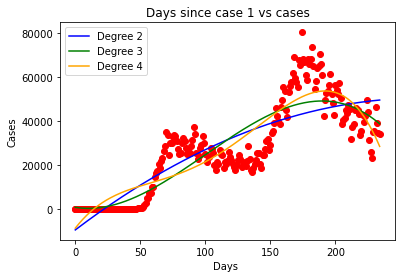

In [223]:
#ploting the data  for polynomial regression 
def viz_poly():
    plt.scatter(X, y, color='red')
    plt.plot(X,poly_regression.predict(poly_features),color='blue', label = "Degree 2")
    plt.plot(X,poly_regression3.predict(poly_features3),color='green', label = "Degree 3")
    plt.plot(X,poly_regression4.predict(poly_features4),color='orange', label = "Degree 4")
    plt.legend(loc="upper left")
    plt.title("Days since case 1 vs cases")
    plt.xlabel("Days ")
    plt.ylabel("Cases")
    plt.show()
    return
viz_poly()

In [224]:
#predict future cases
poly_features_f = poly3.fit_transform(future_dates)
predicted_dates = poly_regression3.predict(poly_features_f)

#display the predicted cases for the future dates
print("Predicted Cases:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', predicted_dates[i])

Predicted Cases:
[235] - [38297.33327666]
[236] - [37775.10105571]
[237] - [37239.09169467]
[238] - [36689.20392268]
[239] - [36125.33646891]
[240] - [35547.3880625]
[241] - [34955.25743261]


In [225]:
#displaying data for the polynomial model
print("Evaluation of the Polynomial-3 model:")
print("Polynomial Coefficients:", poly_regression3.coef_)
print("Polynomial Intercept:", poly_regression3.intercept_)
print("Mean Squared Error:", metrics.mean_squared_error(y,poly_regression3.predict(poly_features3)))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,poly_regression3.predict(poly_features3))))
print("r^2 score:", r2_score(y,poly_regression3.predict(poly_features3)))

Evaluation of the Polynomial-3 model:
Polynomial Coefficients: [[ 0.00000000e+00 -9.78893946e+01  5.06138989e+00 -1.68784745e-02]]
Polynomial Intercept: [832.81655274]
Mean Squared Error: 104805002.68045191
Sqrt of Mean Squared Error: 10237.431449365213
r^2 score: 0.7573867993131935


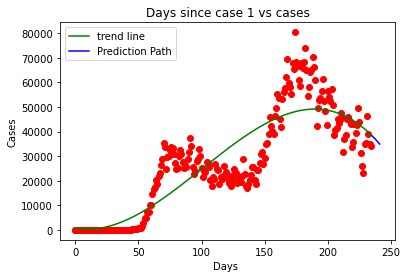

In [226]:
def viz_poly():
    plt.scatter(X, y, color='red')
    plt.plot(X,poly_regression3.predict(poly_features3),color='green', label = "trend line")
    plt.plot(future_dates,poly_regression3.predict(poly_features_f),color='blue', label = "Prediction Path")
    plt.legend(loc="upper left")
    plt.title("Days since case 1 vs cases")
    plt.xlabel("Days ")
    plt.ylabel("Cases")
    plt.show()
    return
viz_poly()

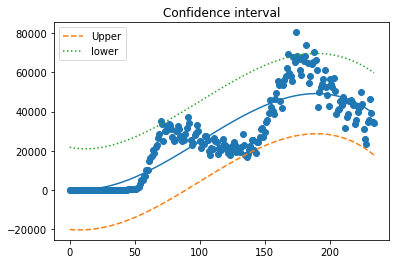

In [228]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)
xp.shape
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot()
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.title("Confidence interval")
plt.legend(loc='upper left')

## Deaths

### Linear Model

In [111]:
#obtain the data for deaths
df_deaths = super_data[['numOfDeathsSinceDay1','Num of Deaths Per Day']]

#display datasets
df_deaths

,numOfDeathsSinceDay1,Num of Deaths Per Day
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
231,217,1068.0
232,218,1093.0
233,219,694.0
234,220,385.0


In [201]:
#obtain x and y variables for deaths
X_d = df_deaths.iloc[:,0].values.reshape(-1, 1) 
y_d = df_deaths.iloc[:,1].values.reshape(-1, 1) 

#make linear regression model and fit the death data
lm = LinearRegression()
lm.fit(X_d, y_d)

#predict the x variable data using the linear regression model
deaths_prediction = lm.predict(X_d)

#display data for the linear model
print("Evaluation of the linear model:")
print("Mean Absolute Error:", metrics.mean_absolute_error(y_d,deaths_prediction))
print("Mean Squared Error:", metrics.mean_squared_error(y_d,deaths_prediction))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_d,deaths_prediction)))
print("r^2 score:", r2_score(y_d,deaths_prediction))

Evaluation of the linear model:
Mean Absolute Error: 528.6189475960541
Mean Squared Error: 474833.3746581803
Sqrt of Mean Squared Error: 689.0815442733757
r^2 score: 0.09763494246679616


In [202]:

future_dates = np.arange(222,229).reshape(-1,1)
#predict the future deaths
future_deaths = lm.predict(future_dates)

#display the predicted deaths for the future dates
print("Predicted Deaths:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', future_deaths[i])

Predicted Deaths:
[222] - [1214.40261831]
[223] - [1217.76488161]
[224] - [1221.12714492]
[225] - [1224.48940822]
[226] - [1227.85167153]
[227] - [1231.21393483]
[228] - [1234.57619814]


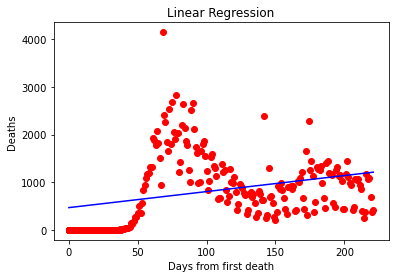

In [203]:
#display deaths and the linear regression model
def viz_linear():
    plt.scatter(X_d, y_d, color='red')
    plt.plot(X_d, lm.predict(X_d), color='blue')
    plt.title('Linear Regression')
    plt.xlabel('Days from first death')
    plt.ylabel('Deaths')
    plt.show()
    return
viz_linear()

In [204]:
#create regression for a polynomial of degree 2
poly_d = PolynomialFeatures(degree = 2)
poly_features_d = poly_d.fit_transform(X_d)
poly_d.fit(X_d,y_d)
poly_regression_d = LinearRegression()
poly_regression_d.fit(poly_features_d,y_d)

#create regression for a polynomial of degree 3
poly_d1 = PolynomialFeatures(degree = 3)
poly_features_d1 = poly_d1.fit_transform(X_d)
poly_d1.fit(X_d,y_d)
poly_regression_d1 = LinearRegression()
poly_regression_d1.fit(poly_features_d1,y_d)

#create regression for a polynomial of degree 4
poly_d2 = PolynomialFeatures(degree = 4)
poly_features_d2 = poly_d2.fit_transform(X_d)
poly_d2.fit(X_d,y_d)
poly_regression_d2 = LinearRegression()
poly_regression_d2.fit(poly_features_d2,y_d)

#create regression for a polynomial of degree 5
poly_d5 = PolynomialFeatures(degree = 5)
poly_features_d5 = poly_d5.fit_transform(X_d)
poly_d5.fit(X_d,y_d)
poly_regression_d5 = LinearRegression()
poly_regression_d5.fit(poly_features_d5,y_d)

LinearRegression()

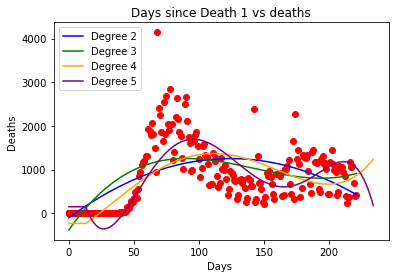

In [205]:
#ploting the data  for polynomial regression 
def viz_poly():
    plt.scatter(X_d, y_d, color='red')
    plt.plot(X_d,poly_regression_d.predict(poly_features_d),color='blue', label = "Degree 2")
    plt.plot(X_d,poly_regression_d1.predict(poly_features_d1),color='green', label = "Degree 3")
    plt.plot(X,poly_regression_d2.predict(poly_features_d2),color='orange', label = "Degree 4")
    plt.plot(X,poly_regression_d5.predict(poly_features_d5),color='purple', label = "Degree 5")
    plt.legend(loc="upper left")
    plt.title("Days since Death 1 vs deaths")
    plt.xlabel("Days ")
    plt.ylabel("Deaths")
    plt.show()
    return
viz_poly()

In [206]:
#predict future deaths 
poly_features_fd = poly_d1.fit_transform(future_dates)
future_deaths = poly_regression_d1.predict(poly_features_fd)

#display the predicted deaths for the future dates
print("Predicted Deaths:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', future_deaths[i])

Predicted Deaths:
[222] - [921.4889259]
[223] - [930.74366356]
[224] - [940.39423189]
[225] - [950.44552513]
[226] - [960.90243755]
[227] - [971.76986337]
[228] - [983.05269685]


In [207]:
#display the data for the polynomial-3 model
print("Evaluation of the Polynomial-3 model:")
print("Polynomial Coefficients:", poly_regression_d1.coef_)
print("Intercept:", poly_regression_d1.intercept_)
print("Mean Squared Error:", metrics.mean_squared_error(y_d,poly_regression_d1.predict(poly_features_d1)))
print("Sqrt Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_d,poly_regression_d1.predict(poly_features_d1))))
print("r^2 score:", r2_score(y_d,poly_regression_d5.predict(poly_features_d5)))

Evaluation of the Polynomial-3 model:
Polynomial Coefficients: [[ 0.00000000e+00  4.28745812e+01 -3.47793111e-01  8.15707694e-04]]
Intercept: [-380.72943167]
Mean Squared Error: 318637.234687762
Sqrt Mean Squared Error: 564.4796140586142
r^2 score: 0.6287643043735861


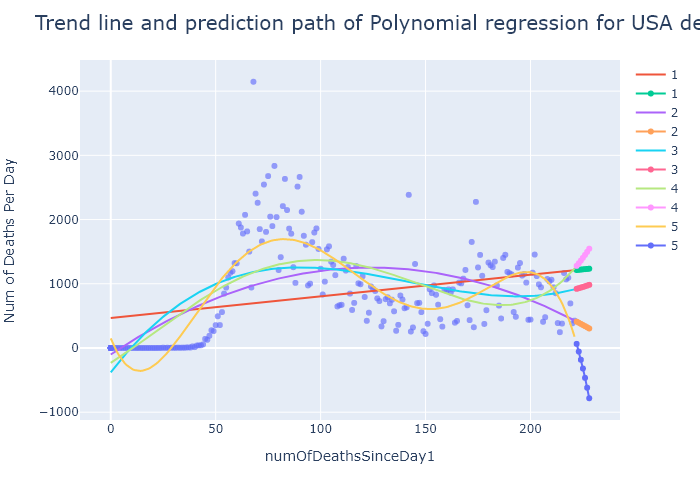

In [213]:
import plotly.express as px
import plotly.graph_objs as go
from IPython.display import Image
X_d = df_deaths.numOfDeathsSinceDay1.values.reshape(-1, 1)
y_d = df_deaths.iloc[:,1].values.reshape(-1, 1) 
x_range = np.linspace(X_d.min(), X_d.max(), 235).reshape(-1, 1)
x_range1 = np.linspace(future_dates.min(), future_dates.max(), 7).reshape(-1, 1)

usa_poly = px.scatter(df_deaths, x='numOfDeathsSinceDay1', y=df_deaths['Num of Deaths Per Day'], opacity=0.65)
for degree in [1, 2, 3, 4, 5]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_d)
    X_poly = poly.fit_transform(X_d)
    x_range_poly = poly.fit_transform(x_range)
    X_poly1 = poly.fit_transform(future_dates)
    x_range_poly1= poly.fit_transform(x_range1)
    
    model = LinearRegression()
    model.fit(X_poly, df_deaths['Num of Deaths Per Day'])
    y_poly = model.predict(x_range_poly)
    y_poly1 = model.predict(x_range_poly1)
   
    usa_poly.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=degree))
    usa_poly.add_traces(go.Scatter(x=x_range1.squeeze(), y=y_poly1, name=degree))
#tx_poly_d.show()
    usa_poly.update_layout(title_text="Trend line and prediction path of Polynomial regression for USA deaths",
                  title_font_size=20)
    
usa_poly.write_image("../images1/usa_poly.png")
img_bytes = usa_poly.to_image(format="png")
Image(img_bytes)

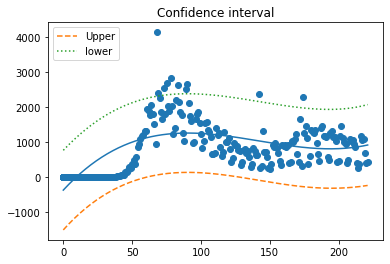

In [119]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X_d)
xp.shape
model = sm.OLS(y_d, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)
plt.title("Confidence interval")
plt.scatter(X_d,y_d)
plt.plot(X_d,ypred)
plt.plot()
plt.plot(X_d,upper,'--',label="Upper") # confid. intrvl
plt.plot(X_d,lower,':',label="lower")
plt.legend(loc='upper left')

# Other Countries

In [120]:
#import dataset
other_country_data = pd.read_csv("../data/owid-covid-data.csv")

#selecting "India","Pakistan","Brazil","Russia","Mexico" 
other_country_data = other_country_data[other_country_data["location"].isin(["India","Pakistan","Brazil","Russia","Mexico"])]

#Fill the missing data values with 0
other_country_data = other_country_data.fillna(0)

#Convertion to date format and stripping time
other_country_data['date'] = other_country_data.date.apply(lambda d: datetime.strptime(d, '%Y-%m-%d'))

#Remove unneeded columns
other_country_data = other_country_data[['location','date','new_cases','new_deaths']]

#groupby location and date
other_country_data = other_country_data.groupby(['location','date'])['new_cases','new_deaths'].sum().reset_index()

#display dataset
other_country_data

C:\Users\nikit\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (1,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,location,date,new_cases,new_deaths
0,Brazil,2019-12-31,0.0,0.0
1,Brazil,2020-01-01,0.0,0.0
2,Brazil,2020-01-02,0.0,0.0
3,Brazil,2020-01-03,0.0,0.0
4,Brazil,2020-01-04,0.0,0.0
...,...,...,...,...
1430,Russia,2020-10-08,11115.0,202.0
1431,Russia,2020-10-09,11493.0,191.0
1432,Russia,2020-10-10,12126.0,201.0
1433,Russia,2020-10-11,12846.0,197.0


## Brazil

In [121]:
#obtain the data for the country of brazil
df_brazil = other_country_data[other_country_data.location =='Brazil']

#obtain the date of the first case
first_case_index = df_brazil['new_cases'].ne(0).idxmax() 

#obtain the date of the first death
first_death_index = df_brazil['new_deaths'].ne(0).idxmax() 

#list to hold the cases since day 1
numOfCasesSinceDay1 = []

#list to hold the deaths since day 1
numOfDeathsSinceDay1 = []

#loop to compute the number of cases since day 1
counter = 1
for i, index in enumerate(range(len(df_brazil))):
    if i <= first_case_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1

#loop to compute the number of deaths since day 1
counter=1
for i,index in enumerate(range(len(df_brazil))):
    if i<=first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1

#insert list into dataset as a column
df_brazil.insert(2, "numOfCasesSinceDay1", numOfCasesSinceDay1)

#insert list into dataset as a column   
df_brazil.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)

#print dataset
df_brazil.tail()

,location,date,numOfDeathsSinceDay1,numOfCasesSinceDay1,new_cases,new_deaths
282,Brazil,2020-10-08,204,225,31553.0,734.0
283,Brazil,2020-10-09,205,226,27750.0,729.0
284,Brazil,2020-10-10,206,227,27444.0,682.0
285,Brazil,2020-10-11,207,228,26749.0,559.0
286,Brazil,2020-10-12,208,229,12345.0,290.0


### Linear Model Cases

In [122]:
#create second dataframe of just the cases data
df = df_brazil[['numOfCasesSinceDay1','new_cases']]

#obtain x and y variables for cases
X = df.iloc[:,0].values.reshape(-1, 1) 
y = df.iloc[:,1].values.reshape(-1, 1) 

#make linear regression model and fit the cases data
lm = LinearRegression()
lm.fit(X, y)

#predict the x variable data using the linear regression model
cases_prediction = lm.predict(X)

#display data for the linear model
print("Evaluation of the linear model:")
print("Mean Absolute Error:", metrics.mean_absolute_error(y,cases_prediction))
print("Mean Squared Error:", metrics.mean_squared_error(y,cases_prediction))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,cases_prediction)))
print("r^2 score:", r2_score(y,cases_prediction))

#predict the future deaths
future_cases = lm.predict(future_dates)

#display the predicted cases for the future dates
print("\nPredicted Deaths:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', future_cases[i])

Evaluation of the linear model:
Mean Absolute Error: 7860.373648972209
Mean Squared Error: 129252184.37755273
Sqrt of Mean Squared Error: 11368.9130693111
r^2 score: 0.6235803700082017

Predicted Deaths:
[235] - [45713.36546531]
[236] - [45908.56745725]
[237] - [46103.76944918]
[238] - [46298.97144112]
[239] - [46494.17343306]
[240] - [46689.375425]
[241] - [46884.57741693]


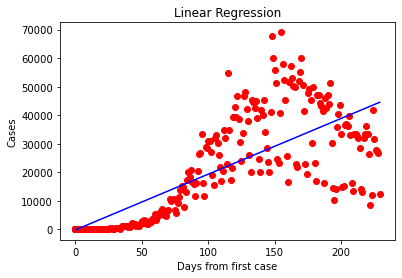

In [123]:
#display cases and the linear regression model
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lm.predict(X), color='blue')
    plt.title('Linear Regression')
    plt.xlabel('Days from first case')
    plt.ylabel('Cases')
    plt.show()
    return
viz_linear()

### Polynomial Model Cases

In [124]:
#create regression for a polynomial of degree 2
poly = PolynomialFeatures(degree = 2)
poly_features = poly.fit_transform(X)
poly.fit(X,y)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,y)

#create regression for a polynomial of degree 3
poly3 = PolynomialFeatures(degree = 3)
poly_features3 = poly3.fit_transform(X)
poly3.fit(X,y)
poly_regression3 = LinearRegression()
poly_regression3.fit(poly_features3,y)

#create regression for a polynomial of degree 4
poly4 = PolynomialFeatures(degree = 4)
poly_features4 = poly4.fit_transform(X)
poly3.fit(X,y)
poly_regression4 = LinearRegression()
poly_regression4.fit(poly_features4,y)

LinearRegression()

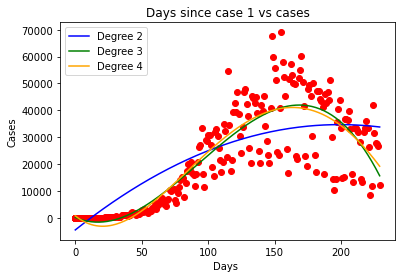

In [125]:
#ploting the data  for polynomial regression 
plt.scatter(X, y, color='red')
plt.plot(X,poly_regression.predict(poly_features),color='blue', label = "Degree 2")
plt.plot(X,poly_regression3.predict(poly_features3),color='green', label = "Degree 3")
plt.plot(X,poly_regression4.predict(poly_features4),color='orange', label = "Degree 4")
plt.legend(loc="upper left")
plt.title("Days since case 1 vs cases")
plt.xlabel("Days ")
plt.ylabel("Cases")
plt.show()

In [126]:
#displaying data for the polynomial model
print("Evaluation of the Polynomial-3 model:")
print("Polynomial Coefficients:", poly_regression3.coef_)
print("Polynomial Intercept:", poly_regression3.intercept_)
print("Mean Squared Error:", metrics.mean_squared_error(y,poly_regression3.predict(poly_features3)))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,poly_regression3.predict(poly_features3))))
print("r^2 score:", r2_score(y,poly_regression3.predict(poly_features3)))

#predict future cases
poly_features_f = poly3.fit_transform(future_dates)
predicted_dates = poly_regression3.predict(poly_features_f)

#display the predicted cases for the future dates
print("\nPredicted Cases:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', predicted_dates[i])

Evaluation of the Polynomial-3 model:
Polynomial Coefficients: [[ 0.00000000e+00 -2.14115527e+02  6.95874887e+00 -2.50131591e-02]]
Polynomial Intercept: [148.33674348]
Mean Squared Error: 69480721.6080889
Sqrt of Mean Squared Error: 8335.509678963183
r^2 score: 0.7976521043320787

Predicted Cases:
[235] - [9510.44152068]
[236] - [8412.18228094]
[237] - [7292.42190561]
[238] - [6151.01031573]
[239] - [4987.79743236]
[240] - [3802.63317653]
[241] - [2595.36746928]


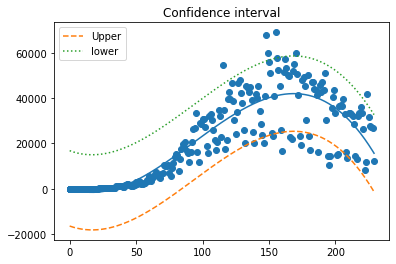

In [127]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)
xp.shape
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)
plt.title("Confidence interval")
plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot()
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

### Linear Model Deaths

In [128]:
#create second dataframe of just the deaths data
df = df_brazil[['numOfDeathsSinceDay1','new_deaths']]

#obtain x and y variables for deaths
X = df.iloc[:,0].values.reshape(-1, 1) 
y = df.iloc[:,1].values.reshape(-1, 1) 

#make linear regression model and fit the deaths data
lm = LinearRegression()
lm.fit(X, y)

#predict the x variable data using the linear regression model
deaths_prediction = lm.predict(X)

#display data for the linear model
print("Evaluation of the linear model:")
print("Mean Absolute Error:", metrics.mean_absolute_error(y,deaths_prediction))
print("Mean Squared Error:", metrics.mean_squared_error(y,deaths_prediction))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,deaths_prediction)))
print("r^2 score:", r2_score(y,deaths_prediction))

#predict the future deaths
future_deaths = lm.predict(future_dates)

#display the predicted deaths for the future dates
print("\nPredicted Deaths:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', future_deaths[i])

Evaluation of the linear model:
Mean Absolute Error: 268.5414016473845
Mean Squared Error: 113158.52092694462
Sqrt of Mean Squared Error: 336.39042930342805
r^2 score: 0.5072874866633752

Predicted Deaths:
[235] - [1309.69937677]
[236] - [1314.63047833]
[237] - [1319.56157988]
[238] - [1324.49268144]
[239] - [1329.423783]
[240] - [1334.35488456]
[241] - [1339.28598612]


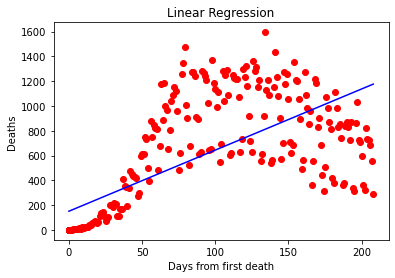

In [129]:
#display deaths and the linear regression model
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lm.predict(X), color='blue')
    plt.title('Linear Regression')
    plt.xlabel('Days from first death')
    plt.ylabel('Deaths')
    plt.show()
    return
viz_linear()

### Polynomial Model Deaths

In [130]:
#create regression for a polynomial of degree 2
poly = PolynomialFeatures(degree = 2)
poly_features = poly.fit_transform(X)
poly.fit(X,y)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,y)

#create regression for a polynomial of degree 3
poly3 = PolynomialFeatures(degree = 3)
poly_features3 = poly3.fit_transform(X)
poly3.fit(X,y)
poly_regression3 = LinearRegression()
poly_regression3.fit(poly_features3,y)

#create regression for a polynomial of degree 4
poly4 = PolynomialFeatures(degree = 4)
poly_features4 = poly4.fit_transform(X)
poly3.fit(X,y)
poly_regression4 = LinearRegression()
poly_regression4.fit(poly_features4,y)

LinearRegression()

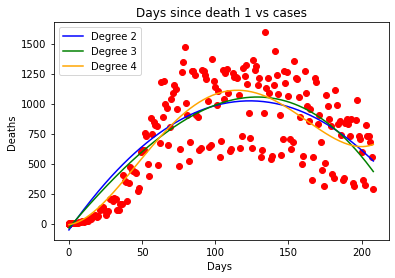

In [131]:
#ploting the data  for polynomial regression 
plt.scatter(X, y, color='red')
plt.plot(X,poly_regression.predict(poly_features),color='blue', label = "Degree 2")
plt.plot(X,poly_regression3.predict(poly_features3),color='green', label = "Degree 3")
plt.plot(X,poly_regression4.predict(poly_features4),color='orange', label = "Degree 4")
plt.legend(loc="upper left")
plt.title("Days since death 1 vs cases")
plt.xlabel("Days ")
plt.ylabel("Deaths")
plt.show()

In [132]:
#displaying data for the polynomial model
print("Evaluation of the Polynomial-3 model:")
print("Polynomial Coefficients:", poly_regression3.coef_)
print("Polynomial Intercept:", poly_regression3.intercept_)
print("Mean Squared Error:", metrics.mean_squared_error(y,poly_regression3.predict(poly_features3)))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,poly_regression3.predict(poly_features3))))
print("r^2 score:", r2_score(y,poly_regression3.predict(poly_features3)))

#predict future cases
poly_features_f = poly3.fit_transform(future_dates)
predicted_dates = poly_regression3.predict(poly_features_f)

#display the predicted cases for the future dates
print("\nPredicted Cases:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', predicted_dates[i])

Evaluation of the Polynomial-3 model:
Polynomial Coefficients: [[ 0.00000000e+00  1.43541592e+01 -2.53456150e-02 -1.57654134e-04]]
Polynomial Intercept: [-36.42131662]
Mean Squared Error: 46073.49442781999
Sqrt of Mean Squared Error: 214.64737228258815
r^2 score: 0.7993877345534768

Predicted Cases:
[235] - [-108.92113869]
[236] - [-132.73541662]
[237] - [-156.82362402]
[238] - [-181.18670684]
[239] - [-205.82561099]
[240] - [-230.74128239]
[241] - [-255.93466698]


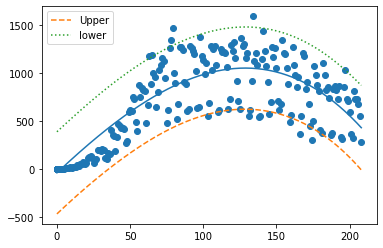

In [133]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)
xp.shape
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot()
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

## Mexico

In [134]:
#obtain the data for the country of brazil
df_mexico = other_country_data[other_country_data.location =='Mexico'].reset_index()

#obtain the date of the first case
first_case_index = df_mexico['new_cases'].ne(0).idxmax() 

#obtain the date of the first death
first_death_index= df_mexico['new_deaths'].ne(0).idxmax() 

#list to hold the cases since day 1
numOfCasesSinceDay1=[]

#list to hold the deaths since day 1
numOfDeathsSinceDay1=[]

#loop to compute the number of cases since day 1
counter=1
for i,index in enumerate(range(len(df_mexico))):
    if i<=first_case_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1

#loop to compute the number of deaths since day 1
counter=1
for i,index in enumerate(range(len(df_mexico))):
    if i<=first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1

#insert list into dataset as a column
df_mexico.insert(2, "numOfCasesSinceDay1", numOfCasesSinceDay1)

#insert list into dataset as a column   
df_mexico.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)

#print dataset
df_mexico.tail()

,index,location,numOfDeathsSinceDay1,numOfCasesSinceDay1,date,new_cases,new_deaths
282,856,Mexico,201,222,2020-10-08,4462.0,369.0
283,857,Mexico,202,223,2020-10-09,30468.0,3013.0
284,858,Mexico,203,224,2020-10-10,5263.0,411.0
285,859,Mexico,204,225,2020-10-11,4577.0,135.0
286,860,Mexico,205,226,2020-10-12,0.0,0.0


### Linear Model Cases

In [135]:
#create second dataframe of just the cases data
df = df_mexico[['numOfCasesSinceDay1','new_cases']]

#obtain x and y variables for cases
X = df.iloc[:,0].values.reshape(-1, 1) 
y = df.iloc[:,1].values.reshape(-1, 1) 

#make linear regression model and fit the cases data
lm = LinearRegression()
lm.fit(X, y)

#predict the x variable data using the linear regression model
cases_prediction = lm.predict(X)

#display data for the linear model
print("Evaluation of the linear model:")
print("Mean Absolute Error:", metrics.mean_absolute_error(y,cases_prediction))
print("Mean Squared Error:", metrics.mean_squared_error(y,cases_prediction))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,cases_prediction)))
print("r^2 score:", r2_score(y,cases_prediction))

#predict the future deaths
future_cases = lm.predict(future_dates)

#display the predicted cases for the future dates
print("\nPredicted Deaths:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', future_cases[i])

Evaluation of the linear model:
Mean Absolute Error: 998.2154840247958
Mean Squared Error: 3757978.5153419115
Sqrt of Mean Squared Error: 1938.550622331517
r^2 score: 0.5991740650353659

Predicted Deaths:
[235] - [7488.12685351]
[236] - [7520.06360057]
[237] - [7552.00034764]
[238] - [7583.93709471]
[239] - [7615.87384178]
[240] - [7647.81058884]
[241] - [7679.74733591]


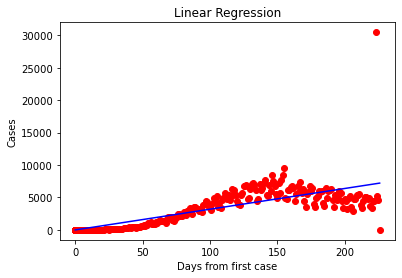

In [136]:
#display cases and the linear regression model
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lm.predict(X), color='blue')
    plt.title('Linear Regression')
    plt.xlabel('Days from first case')
    plt.ylabel('Cases')
    plt.show()
    return
viz_linear()

### Polynomial Model Cases

In [137]:
#create regression for a polynomial of degree 2
poly = PolynomialFeatures(degree = 2)
poly_features = poly.fit_transform(X)
poly.fit(X,y)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,y)

#create regression for a polynomial of degree 3
poly3 = PolynomialFeatures(degree = 3)
poly_features3 = poly3.fit_transform(X)
poly3.fit(X,y)
poly_regression3 = LinearRegression()
poly_regression3.fit(poly_features3,y)

#create regression for a polynomial of degree 4
poly4 = PolynomialFeatures(degree = 4)
poly_features4 = poly4.fit_transform(X)
poly3.fit(X,y)
poly_regression4 = LinearRegression()
poly_regression4.fit(poly_features4,y)

LinearRegression()

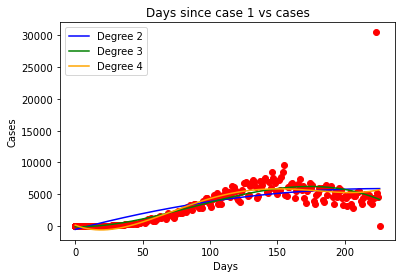

In [138]:
#ploting the data  for polynomial regression 
plt.scatter(X, y, color='red')
plt.plot(X,poly_regression.predict(poly_features),color='blue', label = "Degree 2")
plt.plot(X,poly_regression3.predict(poly_features3),color='green', label = "Degree 3")
plt.plot(X,poly_regression4.predict(poly_features4),color='orange', label = "Degree 4")
plt.legend(loc="upper left")
plt.title("Days since case 1 vs cases")
plt.xlabel("Days ")
plt.ylabel("Cases")
plt.show()

In [139]:
#displaying data for the polynomial model
print("Evaluation of the Polynomial-3 model:")
print("Polynomial Coefficients:", poly_regression3.coef_)
print("Polynomial Intercept:", poly_regression3.intercept_)
print("Mean Squared Error:", metrics.mean_squared_error(y,poly_regression3.predict(poly_features3)))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,poly_regression3.predict(poly_features3))))
print("r^2 score:", r2_score(y,poly_regression3.predict(poly_features3)))

#predict future cases
poly_features_f = poly3.fit_transform(future_dates)
predicted_dates = poly_regression3.predict(poly_features_f)

#display the predicted cases for the future dates
print("\nPredicted Cases:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', predicted_dates[i])

Evaluation of the Polynomial-3 model:
Polynomial Coefficients: [[ 0.         -1.54422389  0.6445568  -0.00245038]]
Polynomial Intercept: [-105.70175209]
Mean Squared Error: 3118465.4751153393
Sqrt of Mean Squared Error: 1765.9177430207046
r^2 score: 0.6673845168046916

Predicted Cases:
[235] - [3326.30255117]
[236] - [3220.64755796]
[237] - [3112.81193729]
[238] - [3002.78098689]
[239] - [2890.54000447]
[240] - [2776.07428772]
[241] - [2659.36913435]


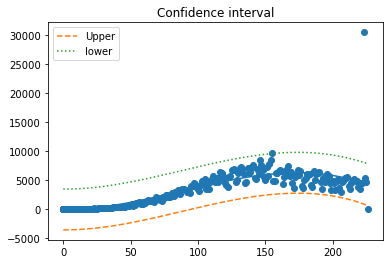

In [140]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)
xp.shape
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)
plt.title("Confidence interval")
plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot()
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

### Linear Model Deaths

In [141]:
#create second dataframe of just the deaths data
df = df_mexico[['numOfDeathsSinceDay1','new_deaths']]

#obtain x and y variables for deaths
X = df.iloc[:,0].values.reshape(-1, 1) 
y = df.iloc[:,1].values.reshape(-1, 1) 

#make linear regression model and fit the deaths data
lm = LinearRegression()
lm.fit(X, y)

#predict the x variable data using the linear regression model
deaths_prediction = lm.predict(X)

#display data for the linear model
print("Evaluation of the linear model:")
print("Mean Absolute Error:", metrics.mean_absolute_error(y,deaths_prediction))
print("Mean Squared Error:", metrics.mean_squared_error(y,deaths_prediction))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,deaths_prediction)))
print("r^2 score:", r2_score(y,deaths_prediction))

#predict the future deaths
future_deaths = lm.predict(future_dates)

#display the predicted deaths for the future dates
print("\nPredicted Deaths:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', future_deaths[i])

Evaluation of the linear model:
Mean Absolute Error: 156.6368794584662
Mean Squared Error: 61551.648459548815
Sqrt of Mean Squared Error: 248.09604684385604
r^2 score: 0.44746476507134914

Predicted Deaths:
[235] - [819.03290859]
[236] - [822.30121087]
[237] - [825.56951316]
[238] - [828.83781544]
[239] - [832.10611772]
[240] - [835.37442]
[241] - [838.64272229]


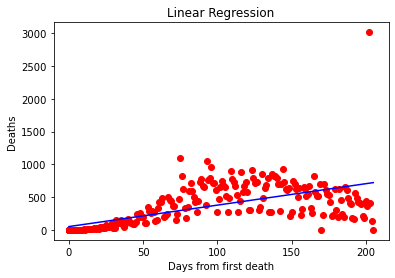

In [142]:
#display deaths and the linear regression model
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lm.predict(X), color='blue')
    plt.title('Linear Regression')
    plt.xlabel('Days from first death')
    plt.ylabel('Deaths')
    plt.show()
    return
viz_linear()

### Polynomial Model Deaths

In [143]:
#create regression for a polynomial of degree 2
poly = PolynomialFeatures(degree = 2)
poly_features = poly.fit_transform(X)
poly.fit(X,y)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,y)

#create regression for a polynomial of degree 3
poly3 = PolynomialFeatures(degree = 3)
poly_features3 = poly3.fit_transform(X)
poly3.fit(X,y)
poly_regression3 = LinearRegression()
poly_regression3.fit(poly_features3,y)

#create regression for a polynomial of degree 4
poly4 = PolynomialFeatures(degree = 4)
poly_features4 = poly4.fit_transform(X)
poly3.fit(X,y)
poly_regression4 = LinearRegression()
poly_regression4.fit(poly_features4,y)

LinearRegression()

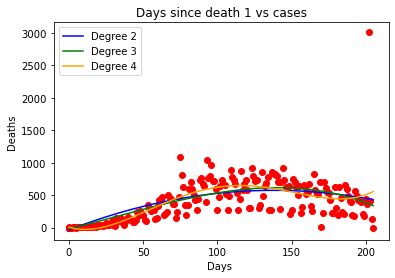

In [144]:
#ploting the data  for polynomial regression 
plt.scatter(X, y, color='red')
plt.plot(X,poly_regression.predict(poly_features),color='blue', label = "Degree 2")
plt.plot(X,poly_regression3.predict(poly_features3),color='green', label = "Degree 3")
plt.plot(X,poly_regression4.predict(poly_features4),color='orange', label = "Degree 4")
plt.legend(loc="upper left")
plt.title("Days since death 1 vs cases")
plt.xlabel("Days ")
plt.ylabel("Deaths")
plt.show()

In [145]:
#displaying data for the polynomial model
print("Evaluation of the Polynomial-3 model:")
print("Polynomial Coefficients:", poly_regression3.coef_)
print("Polynomial Intercept:", poly_regression3.intercept_)
print("Mean Squared Error:", metrics.mean_squared_error(y,poly_regression3.predict(poly_features3)))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,poly_regression3.predict(poly_features3))))
print("r^2 score:", r2_score(y,poly_regression3.predict(poly_features3)))

#predict future cases
poly_features_f = poly3.fit_transform(future_dates)
predicted_dates = poly_regression3.predict(poly_features_f)

#display the predicted cases for the future dates
print("\nPredicted Cases:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', predicted_dates[i])

Evaluation of the Polynomial-3 model:
Polynomial Coefficients: [[ 0.00000000e+00  5.61994265e+00  1.65573600e-02 -1.73052658e-04]]
Polynomial Intercept: [-20.08752504]
Mean Squared Error: 47666.06378011733
Sqrt of Mean Squared Error: 218.32559121669024
r^2 score: 0.5721125200053783

Predicted Cases:
[235] - [-30.87656387]
[236] - [-46.25077899]
[237] - [-61.83692196]
[238] - [-77.63603108]
[239] - [-93.64914469]
[240] - [-109.87730108]
[241] - [-126.32153858]


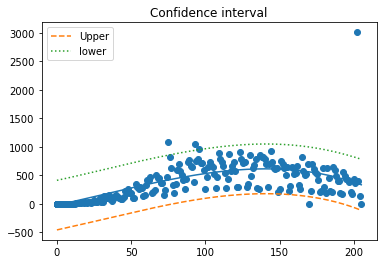

In [146]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)
xp.shape
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)
plt.title("Confidence interval")
plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot()
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

## Russia

In [147]:
#obtain the data for the country of brazil
df_russia = other_country_data[other_country_data.location =='Russia'].reset_index()

#obtain the date of the first case
first_case_index = df_russia['new_cases'].ne(0).idxmax() 

#obtain the date of the first death
first_death_index= df_russia['new_deaths'].ne(0).idxmax() 

#list to hold the cases since day 1
numOfCasesSinceDay1=[]

#list to hold the deaths since day 1
numOfDeathsSinceDay1=[]

#loop to compute the number of cases since day 1
counter=1
for i,index in enumerate(range(len(df_russia))):
    if i<=first_case_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1

#loop to compute the number of deaths since day 1
counter=1
for i,index in enumerate(range(len(df_russia))):
    if i<=first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1

#insert list into dataset as a column
df_russia.insert(2, "numOfCasesSinceDay1", numOfCasesSinceDay1)

#insert list into dataset as a column   
df_russia.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)

#print dataset
df_russia.tail()

,index,location,numOfDeathsSinceDay1,numOfCasesSinceDay1,date,new_cases,new_deaths
282,1430,Russia,195,250,2020-10-08,11115.0,202.0
283,1431,Russia,196,251,2020-10-09,11493.0,191.0
284,1432,Russia,197,252,2020-10-10,12126.0,201.0
285,1433,Russia,198,253,2020-10-11,12846.0,197.0
286,1434,Russia,199,254,2020-10-12,13634.0,143.0


### Linear Model Cases

In [148]:
#create second dataframe of just the cases data
df = df_russia[['numOfCasesSinceDay1','new_cases']]

#obtain x and y variables for cases
X = df.iloc[:,0].values.reshape(-1, 1) 
y = df.iloc[:,1].values.reshape(-1, 1) 

#make linear regression model and fit the cases data
lm = LinearRegression()
lm.fit(X, y)

#predict the x variable data using the linear regression model
cases_prediction = lm.predict(X)

#display data for the linear model
print("Evaluation of the linear model:")
print("Mean Absolute Error:", metrics.mean_absolute_error(y,cases_prediction))
print("Mean Squared Error:", metrics.mean_squared_error(y,cases_prediction))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,cases_prediction)))
print("r^2 score:", r2_score(y,cases_prediction))

#predict the future deaths
future_cases = lm.predict(future_dates)

#display the predicted cases for the future dates
print("\nPredicted Deaths:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', future_cases[i])

Evaluation of the linear model:
Mean Absolute Error: 2149.8007347393996
Mean Squared Error: 6865525.55278062
Sqrt of Mean Squared Error: 2620.2147913445224
r^2 score: 0.5082751893864725

Predicted Deaths:
[235] - [8589.08849381]
[236] - [8622.35576128]
[237] - [8655.62302876]
[238] - [8688.89029623]
[239] - [8722.15756371]
[240] - [8755.42483119]
[241] - [8788.69209866]


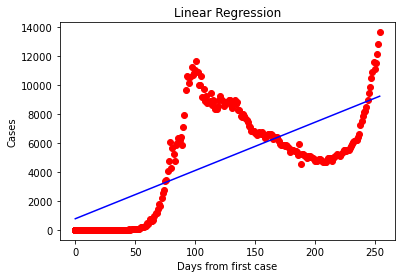

In [149]:
#display cases and the linear regression model
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lm.predict(X), color='blue')
    plt.title('Linear Regression')
    plt.xlabel('Days from first case')
    plt.ylabel('Cases')
    plt.show()
    return
viz_linear()

### Polynomial Model Cases

In [150]:
#create regression for a polynomial of degree 2
poly = PolynomialFeatures(degree = 2)
poly_features = poly.fit_transform(X)
poly.fit(X,y)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,y)

#create regression for a polynomial of degree 3
poly3 = PolynomialFeatures(degree = 3)
poly_features3 = poly3.fit_transform(X)
poly3.fit(X,y)
poly_regression3 = LinearRegression()
poly_regression3.fit(poly_features3,y)

#create regression for a polynomial of degree 4
poly4 = PolynomialFeatures(degree = 4)
poly_features4 = poly4.fit_transform(X)
poly3.fit(X,y)
poly_regression4 = LinearRegression()
poly_regression4.fit(poly_features4,y)

LinearRegression()

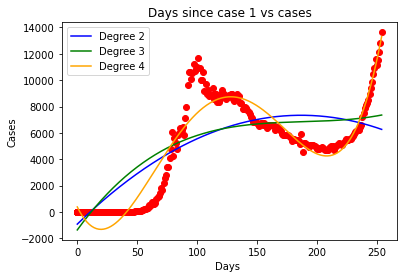

In [151]:
#ploting the data  for polynomial regression 
plt.scatter(X, y, color='red')
plt.plot(X,poly_regression.predict(poly_features),color='blue', label = "Degree 2")
plt.plot(X,poly_regression3.predict(poly_features3),color='green', label = "Degree 3")
plt.plot(X,poly_regression4.predict(poly_features4),color='orange', label = "Degree 4")
plt.legend(loc="upper left")
plt.title("Days since case 1 vs cases")
plt.xlabel("Days ")
plt.ylabel("Cases")
plt.show()

In [152]:
#displaying data for the polynomial model
print("Evaluation of the Polynomial-34 model:")
print("Polynomial Coefficients:", poly_regression3.coef_)
print("Polynomial Intercept:", poly_regression3.intercept_)
print("Mean Squared Error:", metrics.mean_squared_error(y,poly_regression3.predict(poly_features3)))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,poly_regression3.predict(poly_features3))))
print("r^2 score:", r2_score(y,poly_regression3.predict(poly_features3)))

#predict future cases
poly_features_f = poly4.fit_transform(future_dates)
predicted_dates = poly_regression4.predict(poly_features_f)

#display the predicted cases for the future dates
print("\nPredicted Cases:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', predicted_dates[i])

Evaluation of the Polynomial-34 model:
Polynomial Coefficients: [[ 0.00000000e+00  1.25026233e+02 -6.48264510e-01  1.14606248e-03]]
Polynomial Intercept: [-1359.73364367]
Mean Squared Error: 5057391.350092881
Sqrt of Mean Squared Error: 2248.864457919348
r^2 score: 0.6377779407119515

Predicted Cases:
[235] - [6840.80442983]
[236] - [7065.40071276]
[237] - [7301.4569096]
[238] - [7549.22333967]
[239] - [7808.95244665]
[240] - [8080.89879867]
[241] - [8365.31908824]


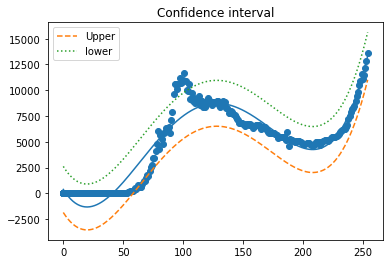

In [153]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=4)
xp = polynomial_features.fit_transform(X)
xp.shape
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)
plt.title("Confidence interval")
plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot()
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

### Linear Model Deaths

In [154]:
#create second dataframe of just the deaths data
df = df_russia[['numOfDeathsSinceDay1','new_deaths']]

#obtain x and y variables for deaths
X = df.iloc[:,0].values.reshape(-1, 1) 
y = df.iloc[:,1].values.reshape(-1, 1) 

#make linear regression model and fit the deaths data
lm = LinearRegression()
lm.fit(X, y)

#predict the x variable data using the linear regression model
deaths_prediction = lm.predict(X)

#display data for the linear model
print("Evaluation of the linear model:")
print("Mean Absolute Error:", metrics.mean_absolute_error(y,deaths_prediction))
print("Mean Squared Error:", metrics.mean_squared_error(y,deaths_prediction))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,deaths_prediction)))
print("r^2 score:", r2_score(y,deaths_prediction))

#predict the future deaths
future_deaths = lm.predict(future_dates)

#display the predicted deaths for the future dates
print("\nPredicted Deaths:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', future_deaths[i])

Evaluation of the linear model:
Mean Absolute Error: 37.38179060991637
Mean Squared Error: 2257.546856148673
Sqrt of Mean Squared Error: 47.51364915630742
r^2 score: 0.5418549887836539

Predicted Deaths:
[235] - [207.57664004]
[236] - [208.35437683]
[237] - [209.13211362]
[238] - [209.90985041]
[239] - [210.6875872]
[240] - [211.46532399]
[241] - [212.24306078]


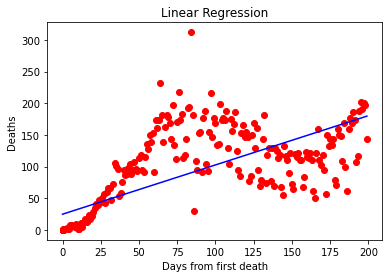

In [155]:
#display deaths and the linear regression model
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lm.predict(X), color='blue')
    plt.title('Linear Regression')
    plt.xlabel('Days from first death')
    plt.ylabel('Deaths')
    plt.show()
    return
viz_linear()

### Polynomial Model Deaths

In [156]:
#create regression for a polynomial of degree 2
poly = PolynomialFeatures(degree = 2)
poly_features = poly.fit_transform(X)
poly.fit(X,y)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,y)

#create regression for a polynomial of degree 3
poly3 = PolynomialFeatures(degree = 3)
poly_features3 = poly3.fit_transform(X)
poly3.fit(X,y)
poly_regression3 = LinearRegression()
poly_regression3.fit(poly_features3,y)

#create regression for a polynomial of degree 4
poly4 = PolynomialFeatures(degree = 4)
poly_features4 = poly4.fit_transform(X)
poly3.fit(X,y)
poly_regression4 = LinearRegression()
poly_regression4.fit(poly_features4,y)

LinearRegression()

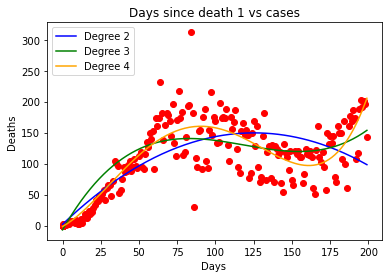

In [157]:
#ploting the data  for polynomial regression 
plt.scatter(X, y, color='red')
plt.plot(X,poly_regression.predict(poly_features),color='blue', label = "Degree 2")
plt.plot(X,poly_regression3.predict(poly_features3),color='green', label = "Degree 3")
plt.plot(X,poly_regression4.predict(poly_features4),color='orange', label = "Degree 4")
plt.legend(loc="upper left")
plt.title("Days since death 1 vs cases")
plt.xlabel("Days ")
plt.ylabel("Deaths")
plt.show()

In [158]:
#displaying data for the polynomial model
print("Evaluation of the Polynomial-3 model:")
print("Polynomial Coefficients:", poly_regression3.coef_)
print("Polynomial Intercept:", poly_regression3.intercept_)
print("Mean Squared Error:", metrics.mean_squared_error(y,poly_regression3.predict(poly_features3)))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,poly_regression3.predict(poly_features3))))
print("r^2 score:", r2_score(y,poly_regression3.predict(poly_features3)))

#predict future cases
poly_features_f = poly3.fit_transform(future_dates)
predicted_dates = poly_regression3.predict(poly_features_f)

#display the predicted cases for the future dates
print("\nPredicted Cases:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', predicted_dates[i])

Evaluation of the Polynomial-3 model:
Polynomial Coefficients: [[ 0.00000000e+00  4.34207487e+00 -4.03084952e-02  1.13297247e-04]]
Polynomial Intercept: [-6.94299172]
Mean Squared Error: 958.944208156026
Sqrt of Mean Squared Error: 30.966824314999204
r^2 score: 0.805392519847411

Predicted Cases:
[235] - [257.76546813]
[236] - [261.97275104]
[237] - [266.25984586]
[238] - [270.62743238]
[239] - [275.07619038]
[240] - [279.60679964]
[241] - [284.21993994]


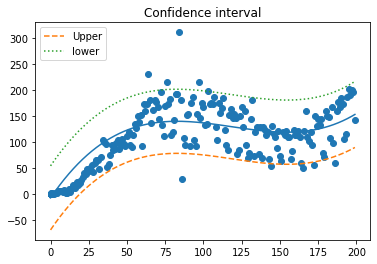

In [159]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)
xp.shape
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)
plt.title("Confidence interval")
plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot()
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

## India

In [160]:
#obtain the data for the country of brazil
df_india = other_country_data[other_country_data.location =='India'].reset_index()

#obtain the date of the first case
first_case_index = df_india['new_cases'].ne(0).idxmax() 

#obtain the date of the first death
first_death_index= df_india['new_deaths'].ne(0).idxmax() 

#list to hold the cases since day 1
numOfCasesSinceDay1=[]

#list to hold the deaths since day 1
numOfDeathsSinceDay1=[]

#loop to compute the number of cases since day 1
counter=1
for i,index in enumerate(range(len(df_india))):
    if i<=first_case_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1

#loop to compute the number of deaths since day 1
counter=1
for i,index in enumerate(range(len(df_india))):
    if i<=first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1

#insert list into dataset as a column
df_india.insert(2, "numOfCasesSinceDay1", numOfCasesSinceDay1)

#insert list into dataset as a column   
df_india.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)

#print dataset
df_india.tail()

,index,location,numOfDeathsSinceDay1,numOfCasesSinceDay1,date,new_cases,new_deaths
282,569,India,209,252,2020-10-08,78524.0,971.0
283,570,India,210,253,2020-10-09,70496.0,964.0
284,571,India,211,254,2020-10-10,73272.0,926.0
285,572,India,212,255,2020-10-11,74383.0,918.0
286,573,India,213,256,2020-10-12,66732.0,816.0


### Linear Model Cases

In [161]:
#create second dataframe of just the cases data
df = df_india[['numOfCasesSinceDay1','new_cases']]

#obtain x and y variables for cases
X = df.iloc[:,0].values.reshape(-1, 1) 
y = df.iloc[:,1].values.reshape(-1, 1) 

#make linear regression model and fit the cases data
lm = LinearRegression()
lm.fit(X, y)

#predict the x variable data using the linear regression model
cases_prediction = lm.predict(X)

#display data for the linear model
print("Evaluation of the linear model:")
print("Mean Absolute Error:", metrics.mean_absolute_error(y,cases_prediction))
print("Mean Squared Error:", metrics.mean_squared_error(y,cases_prediction))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,cases_prediction)))
print("r^2 score:", r2_score(y,cases_prediction))

#predict the future deaths
future_cases = lm.predict(future_dates)

#display the predicted cases for the future dates
print("\nPredicted Deaths:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', future_cases[i])

Evaluation of the linear model:
Mean Absolute Error: 12704.14732844353
Mean Squared Error: 212177124.35061312
Sqrt of Mean Squared Error: 14566.300983798636
r^2 score: 0.7929241619676282

Predicted Deaths:
[235] - [67493.89653065]
[236] - [67848.47149097]
[237] - [68203.0464513]
[238] - [68557.62141162]
[239] - [68912.19637195]
[240] - [69266.77133227]
[241] - [69621.3462926]


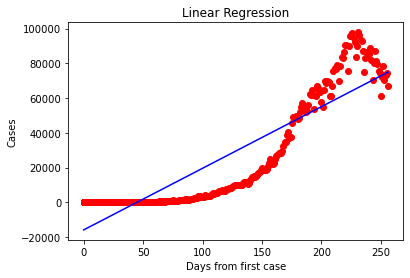

In [162]:
#display cases and the linear regression model
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lm.predict(X), color='blue')
    plt.title('Linear Regression')
    plt.xlabel('Days from first case')
    plt.ylabel('Cases')
    plt.show()
    return
viz_linear()

### Polynomial Model Cases

In [163]:
#create regression for a polynomial of degree 2
poly = PolynomialFeatures(degree = 2)
poly_features = poly.fit_transform(X)
poly.fit(X,y)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,y)

#create regression for a polynomial of degree 3
poly3 = PolynomialFeatures(degree = 3)
poly_features3 = poly3.fit_transform(X)
poly3.fit(X,y)
poly_regression3 = LinearRegression()
poly_regression3.fit(poly_features3,y)

#create regression for a polynomial of degree 4
poly4 = PolynomialFeatures(degree = 4)
poly_features4 = poly4.fit_transform(X)
poly3.fit(X,y)
poly_regression4 = LinearRegression()
poly_regression4.fit(poly_features4,y)

LinearRegression()

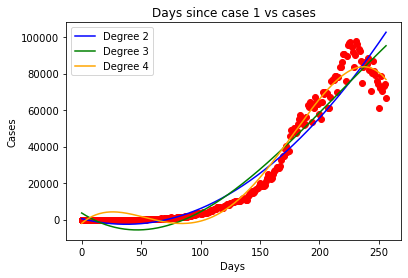

In [164]:
#ploting the data  for polynomial regression 
plt.scatter(X, y, color='red')
plt.plot(X,poly_regression.predict(poly_features),color='blue', label = "Degree 2")
plt.plot(X,poly_regression3.predict(poly_features3),color='green', label = "Degree 3")
plt.plot(X,poly_regression4.predict(poly_features4),color='orange', label = "Degree 4")
plt.legend(loc="upper left")
plt.title("Days since case 1 vs cases")
plt.xlabel("Days ")
plt.ylabel("Cases")
plt.show()

In [165]:
#displaying data for the polynomial model
print("Evaluation of the Polynomial-3 model:")
print("Polynomial Coefficients:", poly_regression3.coef_)
print("Polynomial Intercept:", poly_regression3.intercept_)
print("Mean Squared Error:", metrics.mean_squared_error(y,poly_regression3.predict(poly_features3)))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,poly_regression3.predict(poly_features3))))
print("r^2 score:", r2_score(y,poly_regression3.predict(poly_features3)))

#predict future cases
poly_features_f = poly3.fit_transform(future_dates)
predicted_dates = poly_regression3.predict(poly_features_f)

#display the predicted cases for the future dates
print("\nPredicted Cases:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', predicted_dates[i])

Evaluation of the Polynomial-3 model:
Polynomial Coefficients: [[ 0.00000000e+00 -4.14185105e+02  4.97386138e+00 -7.64835906e-03]]
Polynomial Intercept: [3634.75265597]
Mean Squared Error: 58756565.56477408
Sqrt of Mean Squared Error: 7665.283136634555
r^2 score: 0.942656094093706

Predicted Cases:
[235] - [81723.29978708]
[236] - [82379.26176299]
[237] - [83034.34138523]
[238] - [83688.49276365]
[239] - [84341.67000808]
[240] - [84993.82722838]
[241] - [85644.9185344]


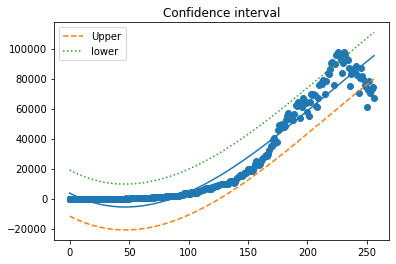

In [166]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)
xp.shape
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)
plt.title("Confidence interval")
plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot()
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

### Linear Model Deaths

In [167]:
#create second dataframe of just the deaths data
df = df_india[['numOfDeathsSinceDay1','new_deaths']]

#obtain x and y variables for deaths
X = df.iloc[:,0].values.reshape(-1, 1) 
y = df.iloc[:,1].values.reshape(-1, 1) 

#make linear regression model and fit the deaths data
lm = LinearRegression()
lm.fit(X, y)

#predict the x variable data using the linear regression model
deaths_prediction = lm.predict(X)

#display data for the linear model
print("Evaluation of the linear model:")
print("Mean Absolute Error:", metrics.mean_absolute_error(y,deaths_prediction))
print("Mean Squared Error:", metrics.mean_squared_error(y,deaths_prediction))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,deaths_prediction)))
print("r^2 score:", r2_score(y,deaths_prediction))

#predict the future deaths
future_deaths = lm.predict(future_dates)

#display the predicted deaths for the future dates
print("\nPredicted Deaths:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', future_deaths[i])

Evaluation of the linear model:
Mean Absolute Error: 108.24281896039616
Mean Squared Error: 22489.826148709668
Sqrt of Mean Squared Error: 149.96608332789674
r^2 score: 0.8797348223205674

Predicted Deaths:
[235] - [1273.07380481]
[236] - [1278.81174949]
[237] - [1284.54969418]
[238] - [1290.28763886]
[239] - [1296.02558355]
[240] - [1301.76352823]
[241] - [1307.50147292]


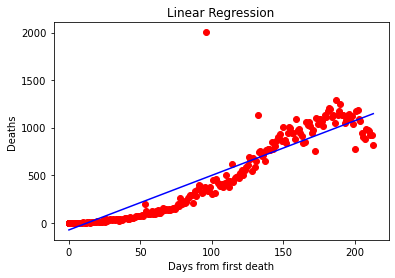

In [168]:
#display deaths and the linear regression model
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lm.predict(X), color='blue')
    plt.title('Linear Regression')
    plt.xlabel('Days from first death')
    plt.ylabel('Deaths')
    plt.show()
    return
viz_linear()

### Polynomial Model Deaths

In [169]:
#create regression for a polynomial of degree 2
poly = PolynomialFeatures(degree = 2)
poly_features = poly.fit_transform(X)
poly.fit(X,y)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,y)

#create regression for a polynomial of degree 3
poly3 = PolynomialFeatures(degree = 3)
poly_features3 = poly3.fit_transform(X)
poly3.fit(X,y)
poly_regression3 = LinearRegression()
poly_regression3.fit(poly_features3,y)

#create regression for a polynomial of degree 4
poly4 = PolynomialFeatures(degree = 4)
poly_features4 = poly4.fit_transform(X)
poly3.fit(X,y)
poly_regression4 = LinearRegression()
poly_regression4.fit(poly_features4,y)

LinearRegression()

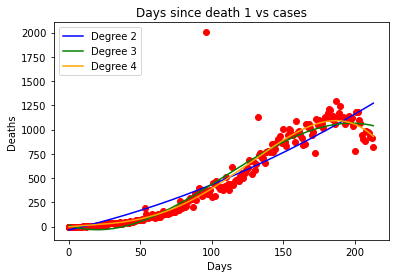

In [170]:
#ploting the data  for polynomial regression 
plt.scatter(X, y, color='red')
plt.plot(X,poly_regression.predict(poly_features),color='blue', label = "Degree 2")
plt.plot(X,poly_regression3.predict(poly_features3),color='green', label = "Degree 3")
plt.plot(X,poly_regression4.predict(poly_features4),color='orange', label = "Degree 4")
plt.legend(loc="upper left")
plt.title("Days since death 1 vs cases")
plt.xlabel("Days ")
plt.ylabel("Deaths")
plt.show()

In [171]:
#displaying data for the polynomial model
print("Evaluation of the Polynomial-3 model:")
print("Polynomial Coefficients:", poly_regression3.coef_)
print("Polynomial Intercept:", poly_regression3.intercept_)
print("Mean Squared Error:", metrics.mean_squared_error(y,poly_regression3.predict(poly_features3)))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,poly_regression3.predict(poly_features3))))
print("r^2 score:", r2_score(y,poly_regression3.predict(poly_features3)))

#predict future cases
poly_features_f = poly3.fit_transform(future_dates)
predicted_dates = poly_regression3.predict(poly_features_f)

#display the predicted cases for the future dates
print("\nPredicted Cases:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', predicted_dates[i])

Evaluation of the Polynomial-3 model:
Polynomial Coefficients: [[ 0.00000000e+00 -4.61447062e+00  1.27551818e-01 -3.90787205e-04]]
Polynomial Intercept: [12.32441018]
Mean Squared Error: 13918.200453595533
Sqrt of Mean Squared Error: 117.97542309140296
r^2 score: 0.9255719079613399

Predicted Cases:
[235] - [900.38549226]
[236] - [890.82836221]
[237] - [880.97298111]
[238] - [870.81700424]
[239] - [860.35808689]
[240] - [849.59388431]
[241] - [838.52205181]


## Pakistan

In [172]:
#obtain the data for the country of brazil
df_pakistan = other_country_data[other_country_data.location =='Pakistan'].reset_index()

#obtain the date of the first case
first_case_index = df_pakistan['new_cases'].ne(0).idxmax() 

#obtain the date of the first death
first_death_index= df_pakistan['new_deaths'].ne(0).idxmax() 

#list to hold the cases since day 1
numOfCasesSinceDay1=[]

#list to hold the deaths since day 1
numOfDeathsSinceDay1=[]

#loop to compute the number of cases since day 1
counter=1
for i,index in enumerate(range(len(df_pakistan))):
    if i<=first_case_index:
        numOfCasesSinceDay1.insert(index, 0) 
    else:
        numOfCasesSinceDay1.insert(index, counter) 
        counter = counter+1

#loop to compute the number of deaths since day 1
counter=1
for i,index in enumerate(range(len(df_pakistan))):
    if i<=first_death_index:
        numOfDeathsSinceDay1.insert(index, 0) 
    else:
        numOfDeathsSinceDay1.insert(index, counter) 
        counter = counter+1

#insert list into dataset as a column
df_pakistan.insert(2, "numOfCasesSinceDay1", numOfCasesSinceDay1)

#insert list into dataset as a column   
df_pakistan.insert(2, "numOfDeathsSinceDay1", numOfDeathsSinceDay1)

#print dataset
df_pakistan.tail()

,index,location,numOfDeathsSinceDay1,numOfCasesSinceDay1,date,new_cases,new_deaths
282,1143,Pakistan,202,224,2020-10-08,583.0,9.0
283,1144,Pakistan,203,225,2020-10-09,661.0,8.0
284,1145,Pakistan,204,226,2020-10-10,671.0,6.0
285,1146,Pakistan,205,227,2020-10-11,666.0,12.0
286,1147,Pakistan,206,228,2020-10-12,0.0,0.0


### Linear Model Cases

In [173]:
#create second dataframe of just the cases data
df = df_pakistan[['numOfCasesSinceDay1','new_cases']]

#obtain x and y variables for cases
X = df.iloc[:,0].values.reshape(-1, 1) 
y = df.iloc[:,1].values.reshape(-1, 1) 

#make linear regression model and fit the cases data
lm = LinearRegression()
lm.fit(X, y)

#predict the x variable data using the linear regression model
cases_prediction = lm.predict(X)

#display data for the linear model
print("Evaluation of the linear model:")
print("Mean Absolute Error:", metrics.mean_absolute_error(y,cases_prediction))
print("Mean Squared Error:", metrics.mean_squared_error(y,cases_prediction))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,cases_prediction)))
print("r^2 score:", r2_score(y,cases_prediction))

#predict the future deaths
future_cases = lm.predict(future_dates)

#display the predicted cases for the future dates
print("\nPredicted Deaths:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', future_cases[i])

Evaluation of the linear model:
Mean Absolute Error: 1078.9811369936563
Mean Squared Error: 2130831.3447846156
Sqrt of Mean Squared Error: 1459.7367381773386
r^2 score: 0.06926407246582167

Predicted Deaths:
[235] - [1878.94131964]
[236] - [1884.27101215]
[237] - [1889.60070466]
[238] - [1894.93039717]
[239] - [1900.26008968]
[240] - [1905.5897822]
[241] - [1910.91947471]


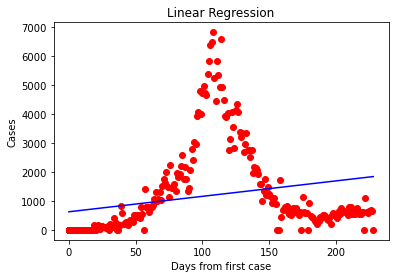

In [174]:
#display cases and the linear regression model
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lm.predict(X), color='blue')
    plt.title('Linear Regression')
    plt.xlabel('Days from first case')
    plt.ylabel('Cases')
    plt.show()
    return
viz_linear()

### Polynomial Model Cases

In [175]:
#create regression for a polynomial of degree 2
poly = PolynomialFeatures(degree = 2)
poly_features = poly.fit_transform(X)
poly.fit(X,y)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,y)

#create regression for a polynomial of degree 3
poly3 = PolynomialFeatures(degree = 3)
poly_features3 = poly3.fit_transform(X)
poly3.fit(X,y)
poly_regression3 = LinearRegression()
poly_regression3.fit(poly_features3,y)

#create regression for a polynomial of degree 4
poly4 = PolynomialFeatures(degree = 4)
poly_features4 = poly4.fit_transform(X)
poly3.fit(X,y)
poly_regression4 = LinearRegression()
poly_regression4.fit(poly_features4,y)

LinearRegression()

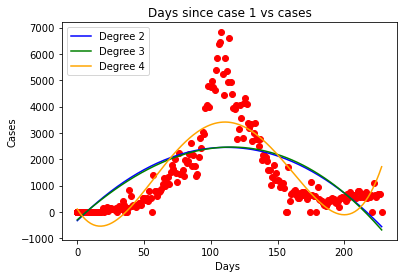

In [176]:
#ploting the data  for polynomial regression 
plt.scatter(X, y, color='red')
plt.plot(X,poly_regression.predict(poly_features),color='blue', label = "Degree 2")
plt.plot(X,poly_regression3.predict(poly_features3),color='green', label = "Degree 3")
plt.plot(X,poly_regression4.predict(poly_features4),color='orange', label = "Degree 4")
plt.legend(loc="upper left")
plt.title("Days since case 1 vs cases")
plt.xlabel("Days ")
plt.ylabel("Cases")
plt.show()

In [177]:
#displaying data for the polynomial model
print("Evaluation of the Polynomial-3 model:")
print("Polynomial Coefficients:", poly_regression3.coef_)
print("Polynomial Intercept:", poly_regression3.intercept_)
print("Mean Squared Error:", metrics.mean_squared_error(y,poly_regression3.predict(poly_features3)))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,poly_regression3.predict(poly_features3))))
print("r^2 score:", r2_score(y,poly_regression3.predict(poly_features3)))

#predict future cases
poly_features_f = poly3.fit_transform(future_dates)
predicted_dates = poly_regression3.predict(poly_features_f)

#display the predicted cases for the future dates
print("\nPredicted Cases:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', predicted_dates[i])

Evaluation of the Polynomial-3 model:
Polynomial Coefficients: [[ 0.00000000e+00  4.56993310e+01 -1.68568982e-01 -1.72123037e-04]]
Polynomial Intercept: [-301.11985608]
Mean Squared Error: 1150206.656298566
Sqrt of Mean Squared Error: 1072.4768791440522
r^2 score: 0.497595780291921

Predicted Cases:
[235] - [-1104.79035062]
[236] - [-1167.12501303]
[237] - [-1230.04053962]
[238] - [-1293.53796313]
[239] - [-1357.6183163]
[240] - [-1422.28263187]
[241] - [-1487.53194258]


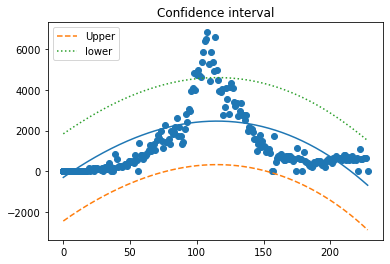

In [178]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)
xp.shape
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)
plt.title("Confidence interval")
plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot()
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')

### Linear Model Deaths

In [179]:
#create second dataframe of just the deaths data
df = df_pakistan[['numOfDeathsSinceDay1','new_deaths']]

#obtain x and y variables for deaths
X = df.iloc[:,0].values.reshape(-1, 1) 
y = df.iloc[:,1].values.reshape(-1, 1) 

#make linear regression model and fit the deaths data
lm = LinearRegression()
lm.fit(X, y)

#predict the x variable data using the linear regression model
deaths_prediction = lm.predict(X)

#display data for the linear model
print("Evaluation of the linear model:")
print("Mean Absolute Error:", metrics.mean_absolute_error(y,deaths_prediction))
print("Mean Squared Error:", metrics.mean_squared_error(y,deaths_prediction))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,deaths_prediction)))
print("r^2 score:", r2_score(y,deaths_prediction))

#predict the future deaths
future_deaths = lm.predict(future_dates)

#display the predicted deaths for the future dates
print("\nPredicted Deaths:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', future_deaths[i])

Evaluation of the linear model:
Mean Absolute Error: 23.854175572553466
Mean Squared Error: 1007.4789703738645
Sqrt of Mean Squared Error: 31.740809226827608
r^2 score: 0.04068611275999845

Predicted Deaths:
[235] - [38.20199752]
[236] - [38.29726188]
[237] - [38.39252624]
[238] - [38.4877906]
[239] - [38.58305496]
[240] - [38.67831932]
[241] - [38.77358368]


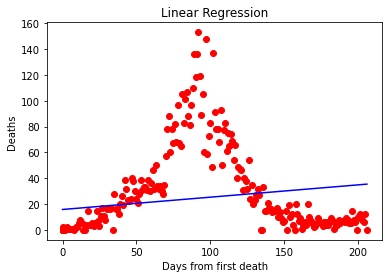

In [180]:
#display deaths and the linear regression model
def viz_linear():
    plt.scatter(X, y, color='red')
    plt.plot(X, lm.predict(X), color='blue')
    plt.title('Linear Regression')
    plt.xlabel('Days from first death')
    plt.ylabel('Deaths')
    plt.show()
    return
viz_linear()

### Polynomial Model Deaths

In [181]:
#create regression for a polynomial of degree 2
poly = PolynomialFeatures(degree = 2)
poly_features = poly.fit_transform(X)
poly.fit(X,y)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,y)

#create regression for a polynomial of degree 3
poly3 = PolynomialFeatures(degree = 3)
poly_features3 = poly3.fit_transform(X)
poly3.fit(X,y)
poly_regression3 = LinearRegression()
poly_regression3.fit(poly_features3,y)

#create regression for a polynomial of degree 4
poly4 = PolynomialFeatures(degree = 4)
poly_features4 = poly4.fit_transform(X)
poly3.fit(X,y)
poly_regression4 = LinearRegression()
poly_regression4.fit(poly_features4,y)

LinearRegression()

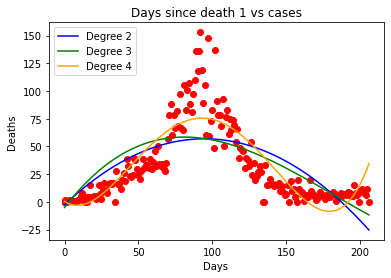

In [182]:
#ploting the data  for polynomial regression 
plt.scatter(X, y, color='red')
plt.plot(X,poly_regression.predict(poly_features),color='blue', label = "Degree 2")
plt.plot(X,poly_regression3.predict(poly_features3),color='green', label = "Degree 3")
plt.plot(X,poly_regression4.predict(poly_features4),color='orange', label = "Degree 4")
plt.legend(loc="upper left")
plt.title("Days since death 1 vs cases")
plt.xlabel("Days ")
plt.ylabel("Deaths")
plt.show()

In [183]:
#displaying data for the polynomial model
print("Evaluation of the Polynomial-3 model:")
print("Polynomial Coefficients:", poly_regression3.coef_)
print("Polynomial Intercept:", poly_regression3.intercept_)
print("Mean Squared Error:", metrics.mean_squared_error(y,poly_regression3.predict(poly_features3)))
print("Sqrt of Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y,poly_regression3.predict(poly_features3))))
print("r^2 score:", r2_score(y,poly_regression3.predict(poly_features3)))

#predict future cases
poly_features_f = poly3.fit_transform(future_dates)
predicted_dates = poly_regression3.predict(poly_features_f)

#display the predicted cases for the future dates
print("\nPredicted Cases:")
for i in range(0, len(future_dates)):
    print(future_dates[i], '-', predicted_dates[i])

Evaluation of the Polynomial-3 model:
Polynomial Coefficients: [[ 0.00000000e+00  1.73118024e+00 -1.37207590e-02  2.50406776e-05]]
Polynomial Intercept: [-5.05422623]
Mean Squared Error: 423.72305029769194
Sqrt of Mean Squared Error: 20.584534250200853
r^2 score: 0.5965341029962858

Predicted Cases:
[235] - [-30.98100313]
[236] - [-31.54600741]
[237] - [-32.10299561]
[238] - [-32.65181748]
[239] - [-33.19232278]
[240] - [-33.72436127]
[241] - [-34.2477827]


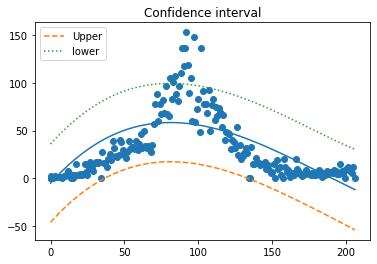

In [184]:
# We know from above that degree 3 fits better without overfitting
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(X)
xp.shape
model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

ypred.shape
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)
plt.title("Confidence interval")
plt.scatter(X,y)
plt.plot(X,ypred)
plt.plot()
plt.plot(X,upper,'--',label="Upper") # confid. intrvl
plt.plot(X,lower,':',label="lower")
plt.legend(loc='upper left')